<h1 style="text-align:center;color:green;font-size:50px;font-family:ALGERIAN;border:solid">Projet de Data Science & Machine Learning </h1>

<h1 style="text-align:center;color:blue;font-size:50px;font-family:times">Ecole Nationale de la Statistique et de l'Analyse Economique Pierre NDIAYE (ENSAE) </h1><br>


<div style="display:flex;text-align:justify">
    
<ul style="text-align:justify;font-family:times;font-size:15px;list-style-type:circle; width:60%"> 
<span style="font-weight:bold">Réalisé par: </span> 
    <ul style="text-align:justify;font-family:times;font-size:18px;list-style-type:circle"> 
        <li>ALAJI BOUHARI Hamissou</li>                                      
        <li>ATSAMA Lianne Cédrique</li>
        <li>FALL Moussa</li>
    </ul>
    <span style="font-style: italic;color:blue;font-size:13px">Eléves Ingénieurs Statisticiens Economistes</span>
</ul>
 
<ul style="text-align:justify;font-family:times;font-size:18px;list-style-type:none;width:39%"> 
 <li style="font-weight:bold">Sous la supervision de:</li> 
<li>Mme Mously DIAW</li>                                     
   
</ul>
    
</div>

<br> </br>
<span style="text-align:center;color:green;font-size:40px;font-family:ALGERIAN;border:solid">    La prédiction des ventes futures </span> <br>
<br> </br>


<div style="display:flex">
    <right style ="width:500%; height:500px"><img src="https://static.doofinder.com/main-files/uploads/previsiones-de-ventas-sales-forecast.jpg"/></right>
</div>

La prédiction des ventes est un usage courant et essentiel de l’apprentissage automatique (ML). Les prévisions de ventes peuvent être utilisées pour déterminer les impacts différentiels de nouvelles initiatives, planifier les ressources en réponse à la demande prévue et projeter les budgets futurs. 
Nous disposons de données historiques quotidiennes sur les ventes. La tâche consiste à prévoir la quantité totale de produits vendus dans chaque magasin pour l'ensemble du test. Notons que la liste des magasins et des produits change légèrement chaque mois. Notre défi est donc la création d'un modèle robuste capable de gérer de telles situations pour la prédiction de ventes futures dans chaque magasin.

## Description de nos données

Nous disposons d'un ensemble de six bases:
- sales_train.csv : l'ensemble d'entraînement, ce sont des données historiques quotidiennes de janvier 2013 à octobre 2015.
- test.csv: l'ensemble de données de test. Nous devons prévoir les ventes de ces magasins et produits pour novembre 2015.
- sample_submission.csv :un exemple de fichier de soumission au bon format.
- items.csv : informations supplémentaires sur les articles/produits.
- item_categories.csv : informations supplémentaires sur les catégories d'articles.
- shops.csv :Informations supplémentaires sur les magasins.

Champs de données

   - ID :un identifiant qui représente un tuple (magasin, article) dans l'ensemble de tests.
   - shop_id : identifiant unique d'une boutique
   - item_id :identifiant unique d'un produit
   - item_category_id : identifiant unique de la catégorie d'un article
   - item_cnt_day :nombre de produits vendus.
   - item_price : prix actuel d'un article
   - date :date au format jj/mm/aaaa
   - date_block_num - un numéro de mois consécutif, utilisé par commodité. Janvier 2013 est 0, février 2013 est 1,..., octobre 2015 est 33.
   - item_name : nom de l'article
   - shop_name :nom du magasin
   - item_category_name :nom de la catégorie de l'article

In [1]:
import pandas as pd
import numpy as np
import datetime
from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm

!pip install chart_studio
!pip install lazypredict
import lazypredict
import matplotlib.pyplot as plt
import missingno as msno
import optuna
import pandas as pd
import pandas_profiling as pp
import plotly.express as px
import scipy as sp
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_california_housing, fetch_openml, load_boston, load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from optuna import Trial
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             #mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
## Importation des données
import os
#afficher le répertoire courant
os.getcwd()
os.chdir(r'C:\Users\dell\Desktop\Cours ISE2\Machine learning\BASE')
sales_train=pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
sample_submission = pd.read_csv('sample_submission.csv')
item_categories = pd.read_csv('item_categories.csv')

In [3]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


In [76]:
#Afficher les bases
print(sales_train.head())
display(test.head())
display(shops.head())
display(items.head())
display(item_categories.head())
display (sample_submission.head())

         date  date_block_num  shop_id  item_id   item_price  item_cnt_day
0  02.01.2013               0       59    22154   999.000000             1
1  03.01.2013               0       25     2552   899.000000             1
2  05.01.2013               0       25     2552   899.000000            -1
3  06.01.2013               0       25     2554  1709.050049             1
4  15.01.2013               0       25     2555  1099.000000             1


ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

item_name  \
0                             ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D   
1  !ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]   
2                         ***В ЛУЧАХ СЛАВЫ   (UNV)                    D   
3                       ***ГОЛУБАЯ ВОЛНА  (Univ)                      D   
4                           ***КОРОБКА (СТЕКЛО)                       D   

   item_id  item_category_id  
0        0                40  
1        1                76  
2        2                40  
3        3                40  
4        4                40

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5

In [4]:
# Fusion des bases afin de faciliter l'exploration de données
base=pd.merge(sales_train, shops, how = 'left', left_on = 'shop_id', right_on = 'shop_id')
base=pd.merge(base, items, left_on = 'item_id', right_on = 'item_id', how='left' )
base=pd.merge(base,item_categories, left_on = 'item_category_id', right_on = 'item_category_id', how='left')
base.head()
base.shape
base.head

<bound method NDFrame.head of                date  date_block_num  shop_id  item_id   item_price  \
0        02.01.2013               0       59    22154   999.000000   
1        03.01.2013               0       25     2552   899.000000   
2        05.01.2013               0       25     2552   899.000000   
3        06.01.2013               0       25     2554  1709.050049   
4        15.01.2013               0       25     2555  1099.000000   
...             ...             ...      ...      ...          ...   
2935844  10.10.2015              33       25     7409   299.000000   
2935845  09.10.2015              33       25     7460   299.000000   
2935846  14.10.2015              33       25     7459   349.000000   
2935847  22.10.2015              33       25     7440   299.000000   
2935848  03.10.2015              33       25     7460   299.000000   

         item_cnt_day               shop_name  \
0                   1  Ярославль ТЦ "Альтаир"   
1                   1     Москв

## Analyse Exploratoire De Données (EDA)

In [5]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

### EDA des sales_train

In [6]:
sales_train['year'] = pd.DatetimeIndex(sales_train['date']).year
sales_train.year.unique()

c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '15.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '13.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '16.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '26.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent pars

array([2013, 2014, 2015], dtype=int64)

In [8]:
sales_train['day'] = pd.DatetimeIndex(sales_train['date']).day

c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '15.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '13.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '16.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '26.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent pars

In [9]:
sales_train['month'] = pd.DatetimeIndex(sales_train['date']).month
sales_train.head()

c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '15.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '13.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '16.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\indexes\datetimes.py:327: UserWarning: Parsing '26.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent pars

date  date_block_num  shop_id  item_id   item_price  item_cnt_day  \
0  02.01.2013               0       59    22154   999.000000             1   
1  03.01.2013               0       25     2552   899.000000             1   
2  05.01.2013               0       25     2552   899.000000            -1   
3  06.01.2013               0       25     2554  1709.050049             1   
4  15.01.2013               0       25     2555  1099.000000             1   

   year  month  day  
0  2013      2    1  
1  2013      3    1  
2  2013      5    1  
3  2013      6    1  
4  2013      1   15

<AxesSubplot:>

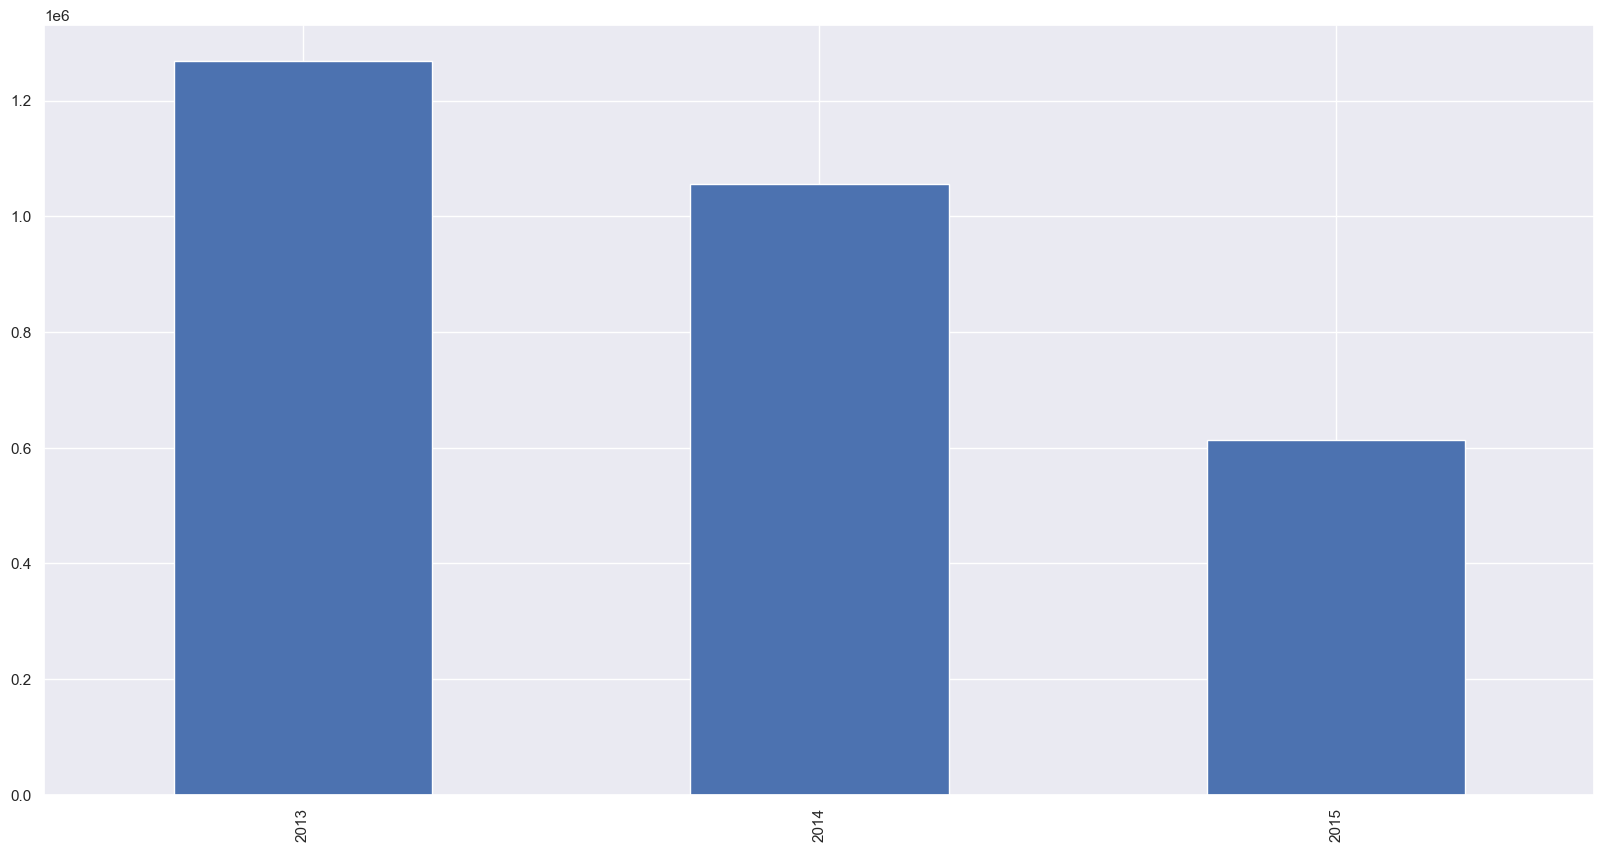

In [10]:


sales_train.year.value_counts().plot.bar()

In [82]:
# les ventes pour les mois de l'année 2013
sales_train[sales_train['year'] == 2013].month.value_counts()

12    144640
3     115446
2     111556
8     109222
7     108710
1     101172
6     100825
9      99521
10     95827
4      95361
5      93685
11     91597
Name: month, dtype: int64

<AxesSubplot:xlabel='month'>

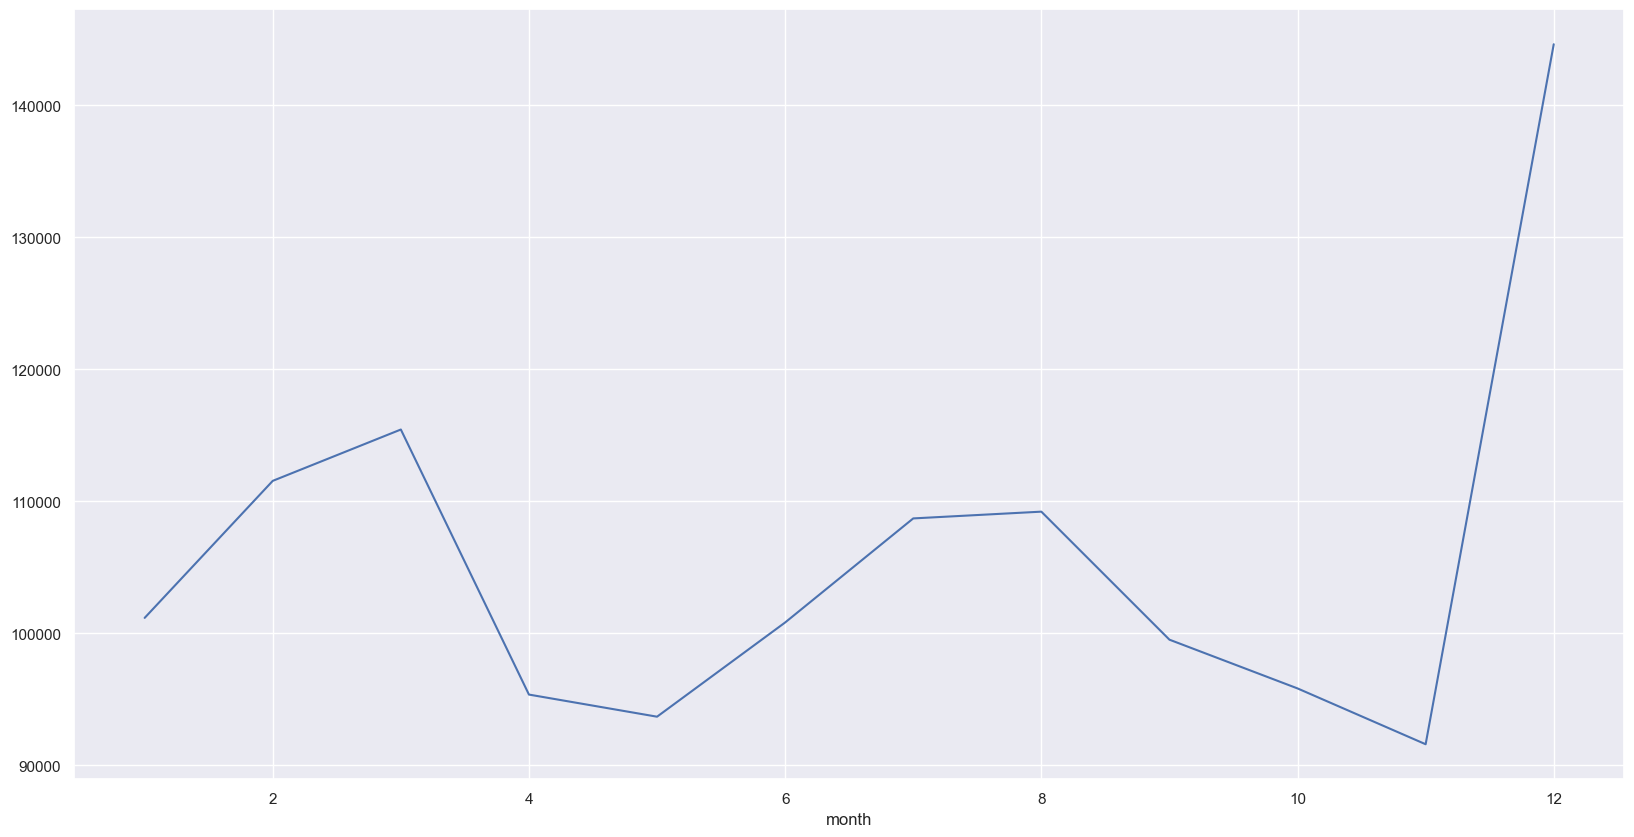

In [11]:
sales_train.groupby(sales_train[sales_train['year']==2013].month).count()['item_id'].plot()

In [12]:
#  les ventes pour les mois de l'année 2014
sales_train[sales_train['year'] == 2014].month.value_counts()

12    132845
8      91779
2      89804
3      87963
11     86056
1      85738
6      83718
5      83626
7      81601
4      80143
9      77637
10     74951
Name: month, dtype: int64

<AxesSubplot:xlabel='month'>

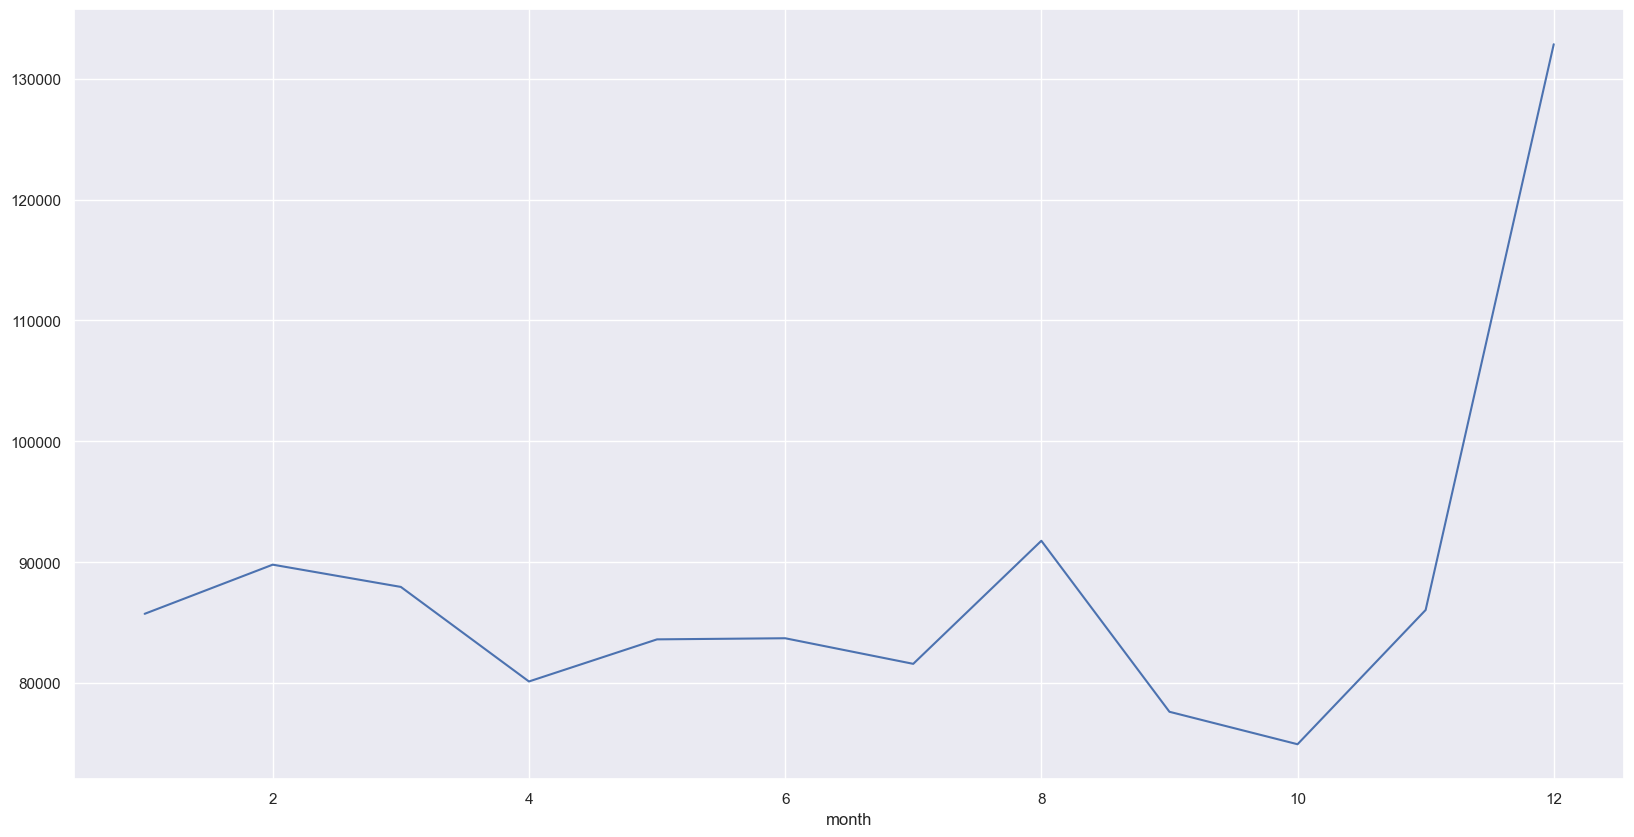

In [13]:
sales_train.groupby(sales_train[sales_train['year']==2014].month).count()['item_id'].plot()

In [14]:
#  les ventes pour les mois de l'année 2015
sales_train[sales_train['year'] == 2015].month.value_counts()

2     67390
1     64320
3     63122
8     58771
7     56030
4     55560
5     55545
6     53789
10    51904
9     46928
11    20815
12    18252
Name: month, dtype: int64

<AxesSubplot:xlabel='month'>

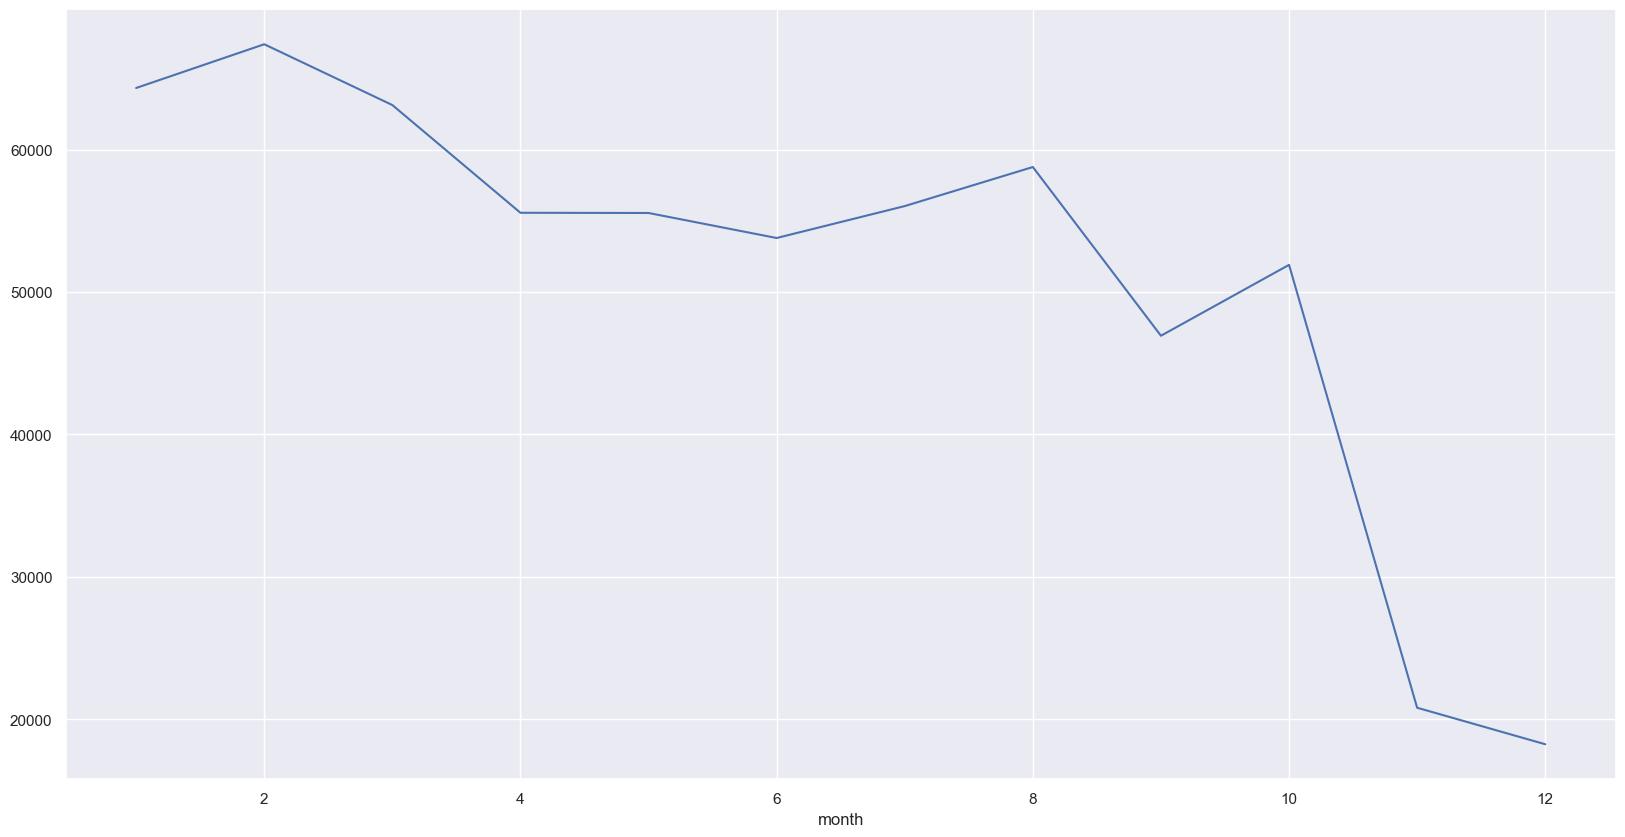

In [15]:
sales_train.groupby(sales_train[sales_train['year']==2015].month).count()['item_id'].plot()

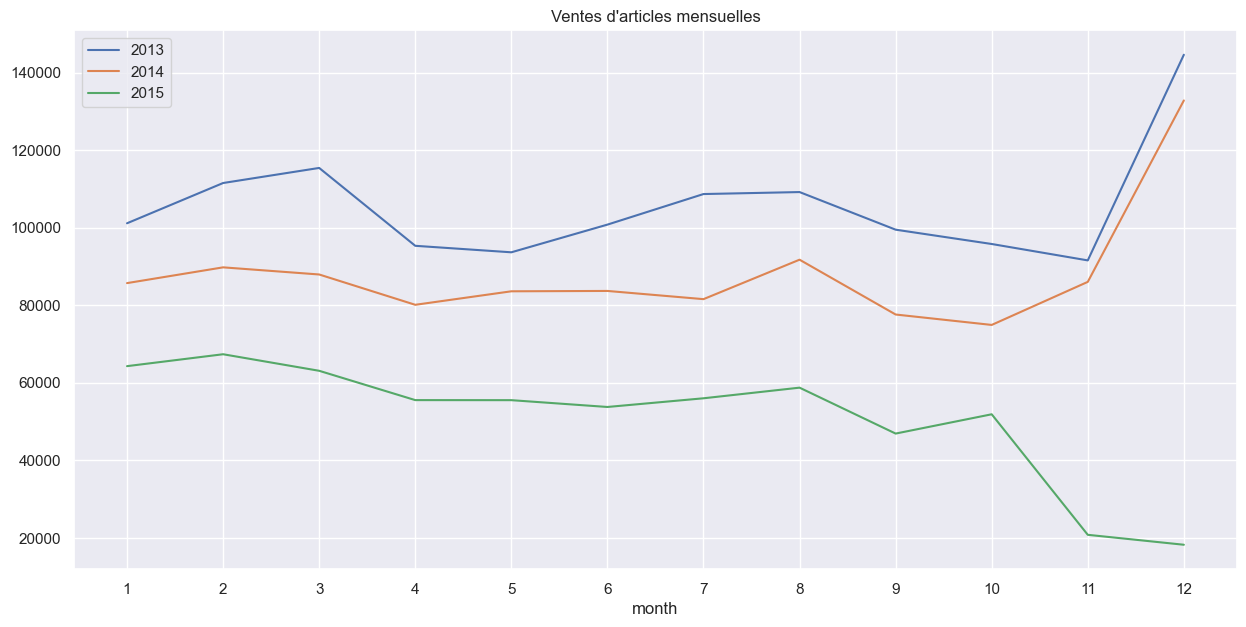

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
plt.xticks([i for i in range(1,13)])
sales_train.groupby(sales_train[sales_train['year']==2013].month).count()['item_id'].plot(ax=ax,label=2013)
sales_train.groupby(sales_train[sales_train['year']==2014].month).count()['item_id'].plot(label=2014)
sales_train.groupby(sales_train[sales_train['year']==2015].month).count()['item_id'].plot(label=2015)
plt.grid("on")
plt.title("Ventes d'articles mensuelles")
plt.legend()

In [17]:
# Informations sur la base
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int8   
 2   shop_id             int8   
 3   item_id             int16  
 4   item_price          float32
 5   item_cnt_day        int16  
 6   shop_name           object 
 7   item_name           object 
 8   item_category_id    int8   
 9   item_category_name  object 
dtypes: float32(1), int16(2), int8(3), object(4)
memory usage: 142.8+ MB


In [18]:
#Ici on voit que la date n'est pas en format date
## Mettons la date en format date
base['date'] = pd.to_datetime(base['date'], infer_datetime_format=True)
base.info()

c:\Users\dell\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\dell\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '26.01.2013' in DD/MM/YYYY format. Provide format or specify in

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int8          
 2   shop_id             int8          
 3   item_id             int16         
 4   item_price          float32       
 5   item_cnt_day        int16         
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int8          
 9   item_category_name  object        
dtypes: datetime64[ns](1), float32(1), int16(2), int8(3), object(3)
memory usage: 142.8+ MB


In [90]:
base['date'].max()

Timestamp('2015-12-10 00:00:00')

In [91]:
base['date'].min()

Timestamp('2013-01-01 00:00:00')

In [19]:
#vérifions s'il y'a des doublons
display(base.duplicated())
base.duplicated().sum()

0          False
1          False
2          False
3          False
4          False
           ...  
2935844    False
2935845    False
2935846    False
2935847    False
2935848    False
Length: 2935849, dtype: bool

6

In [20]:
#Affichons uniquement les doublons
base[base.duplicated()] 

date  date_block_num  shop_id  item_id  item_price  \
76962   2013-05-01               0       54    20130       149.0   
1435367 2014-02-23              13       50     3423       999.0   
1496766 2014-03-23              14       21     3423       999.0   
1671873 2014-01-05              16       50     3423       999.0   
1866340 2014-12-07              18       25     3423       999.0   
2198566 2014-12-31              23       42    21619       499.0   

         item_cnt_day               shop_name  \
76962               1         Химки ТЦ "Мега"   
1435367             1      Тюмень ТЦ "Гудвин"   
1496766             1  Москва МТРЦ "Афи Молл"   
1671873             1      Тюмень ТЦ "Гудвин"   
1866340             1     Москва ТРК "Атриум"   
2198566             1  СПб ТК "Невский Центр"   

                                               item_name  item_category_id  \
76962                            УЧЕНИК ЧАРОДЕЯ (регион)                40   
1435367  Far Cry 3 (Classics) [Xbox 360, русская версия]                23   
1496766  Far Cry 3 (Classics) [Xbox 360, русская версия]                23   
1671873  Far Cry 3 (Classics) [Xbox 360, русская версия]                23   
1866340  Far Cry 3 (Classics) [Xbox 360, русская версия]                23   
2198566                               ЧЕЛОВЕК ДОЖДЯ (BD)                37   

        item_category_name  
76962           Кино - DVD  
1435367    Игры - XBOX 360  
1496766    Игры - XBOX 360  
1671873    Игры - XBOX 360  
1866340    Игры - XBOX 360  
2198566     Кино - Blu-Ray

In [21]:
#Suppression des doublons
base.drop_duplicates(keep = 'first', inplace = True)#inplace=true= est utilisé selon que nous voulons apporter des modifications à la DF d’origine ou non.
base.duplicated().sum()


0

In [22]:
#compter le nombre de valeurs manquantes
base.isnull().sum() 
base.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

In [23]:
base.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06   
mean     1.456991e+01  3.300171e+01  1.019723e+04  8.906237e+02  1.242641e+00   
std      9.422992e+00  1.622698e+01  6.324293e+03  1.726442e+03  2.618837e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01   
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

       item_category_id  
count      2.935843e+06  
mean       4.000141e+01  
std        1.710076e+01  
min        0.000000e+00  
25%        2.800000e+01  
50%        4.000000e+01  
75%        5.500000e+01  
max        8.300000e+01

In [97]:
base.nunique()

date                   1034
date_block_num           34
shop_id                  60
item_id               21807
item_price            19992
item_cnt_day            198
shop_name                60
item_name             21807
item_category_id         84
item_category_name       84
dtype: int64

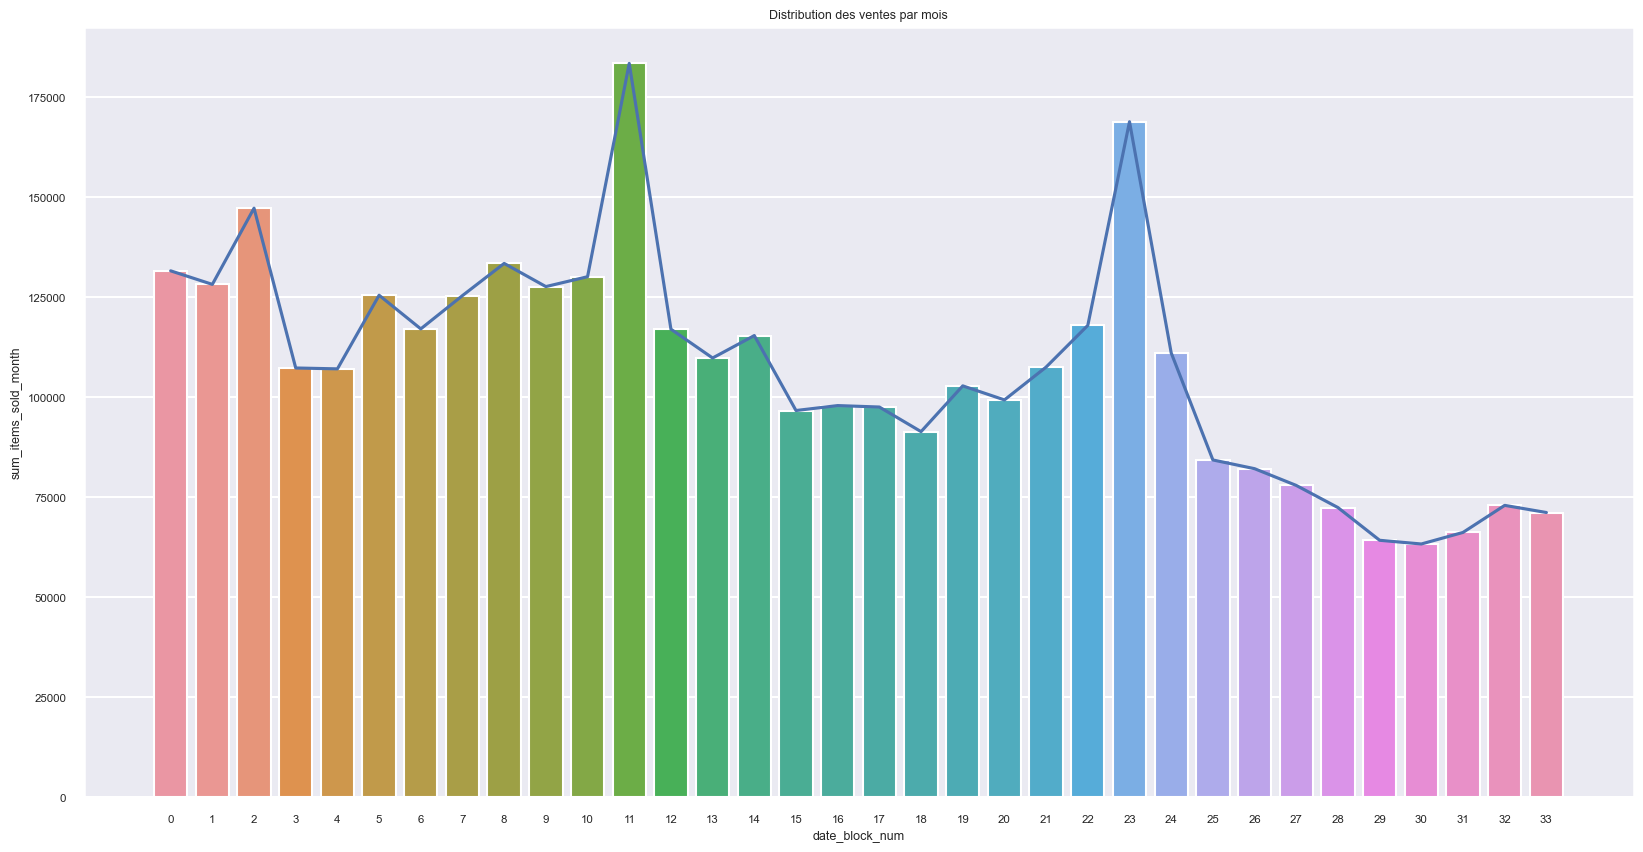

In [24]:
#Conversion des données journalières à des données mensuelles
sns.set_context("talk", font_scale=0.5)

sales_month = pd.DataFrame(sales_train.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold_month']
# Diagramme en barres
sns.barplot(x ='date_block_num', y='sum_items_sold_month', data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold_month)

plt.title('Distribution des ventes par mois')
del sales_month 

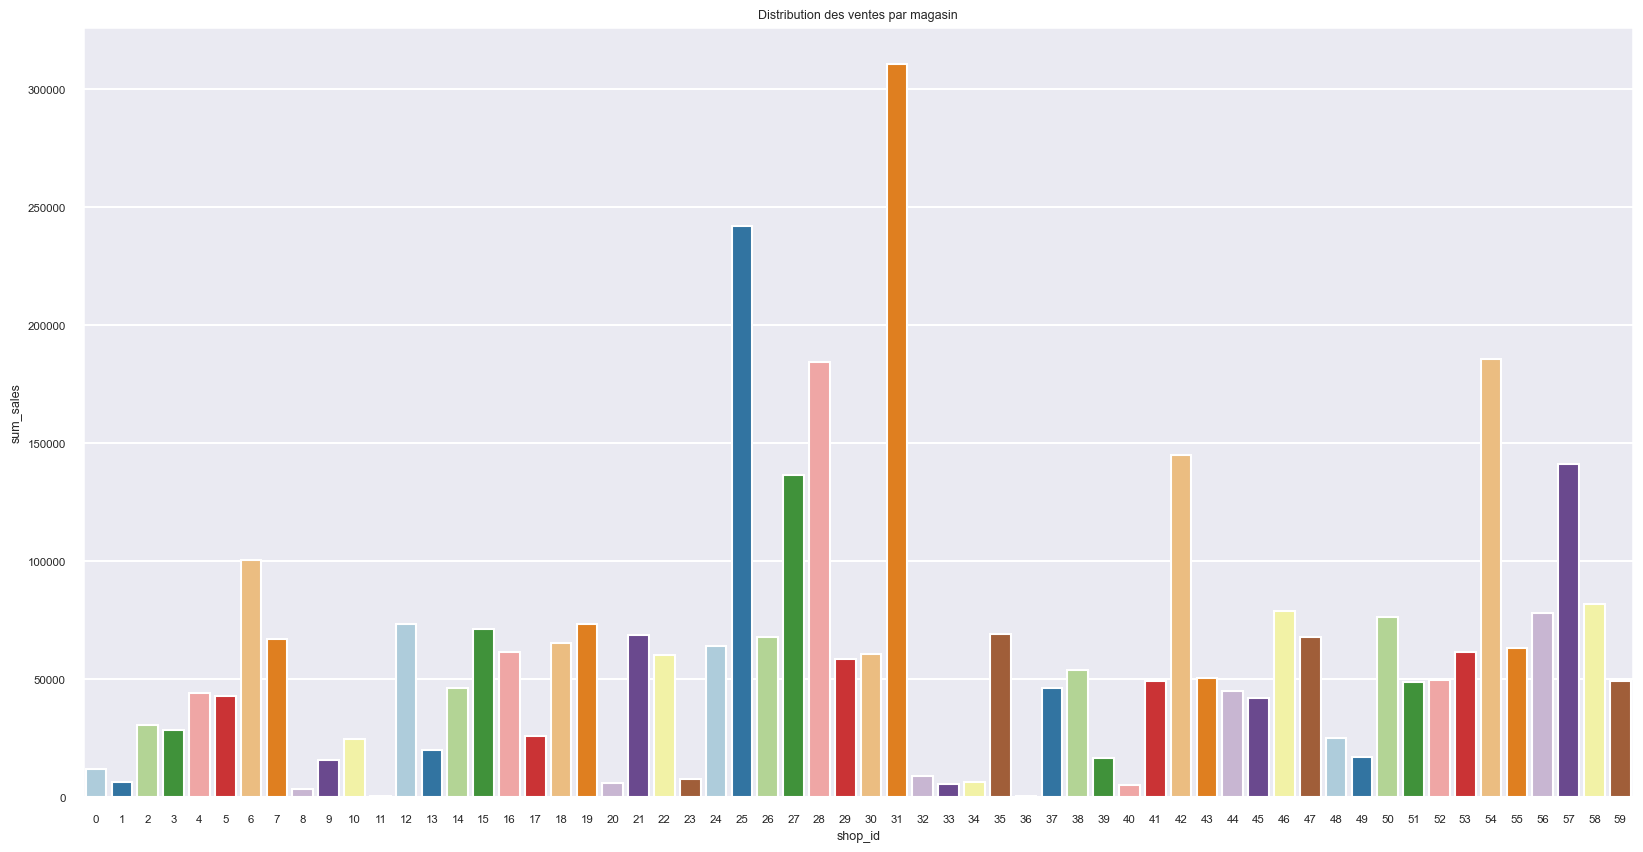

In [99]:
sns.set_context("talk", font_scale=0.5)
sales_month_shop_id = pd.DataFrame(sales_train.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution des ventes par magasin');
del sales_month_shop_id

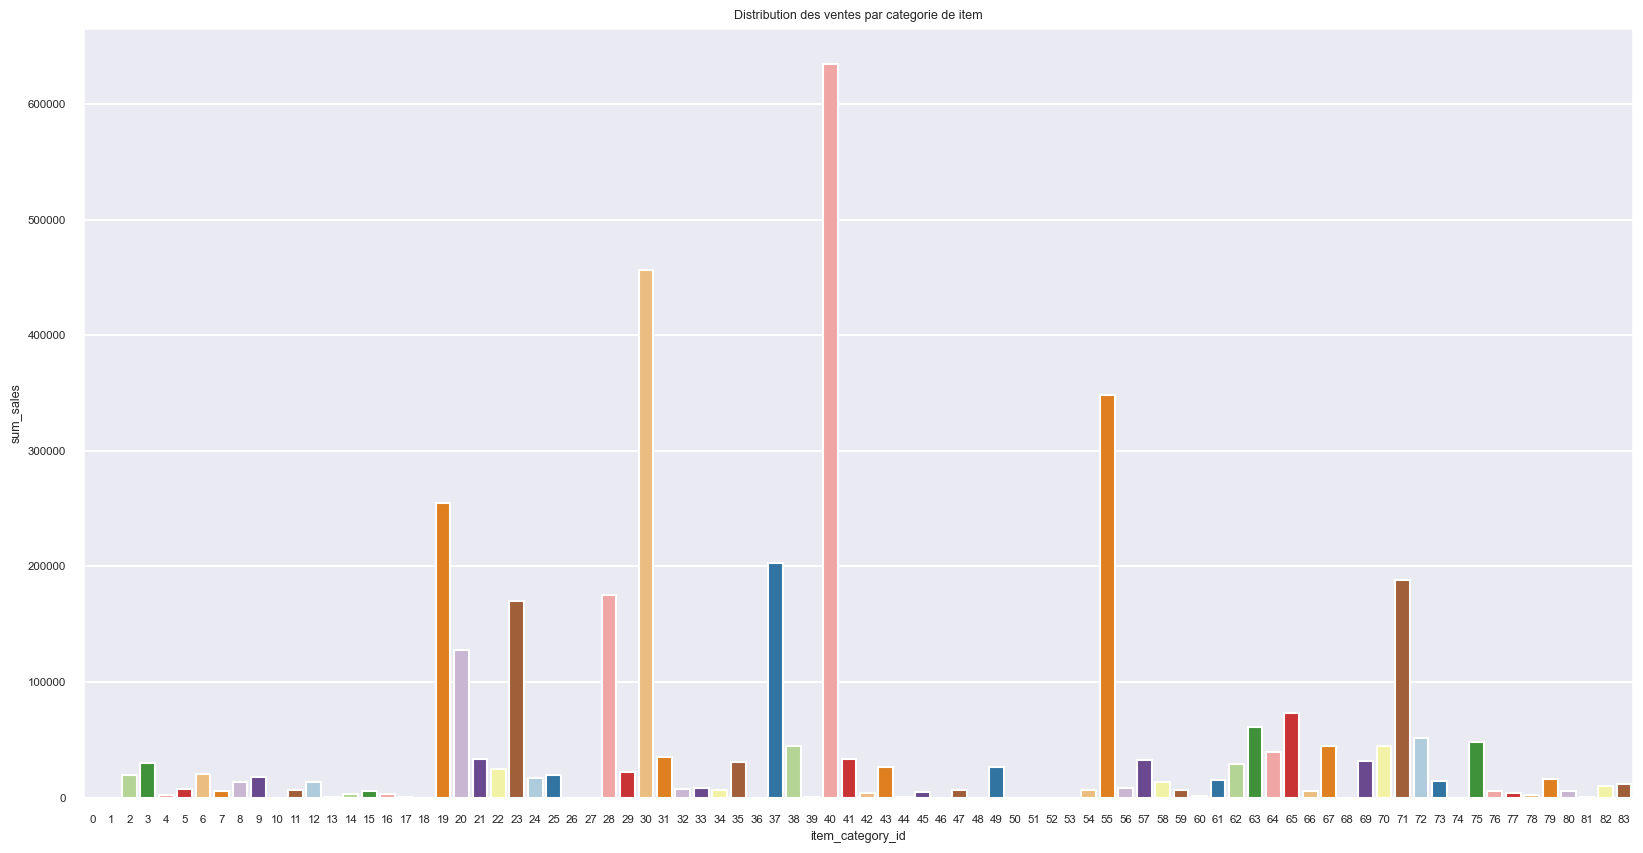

In [100]:
sns.set_context("talk", font_scale=0.5)
sales_item_cat= pd.DataFrame(base.groupby(['item_category_id']).sum().item_cnt_day).reset_index()
sales_item_cat.columns = ['item_category_id', 'sum_sales']
sns.barplot(x ='item_category_id', y='sum_sales', data=sales_item_cat.reset_index(), palette='Paired');
del sales_item_cat
plt.title('Distribution des ventes par categorie de item');

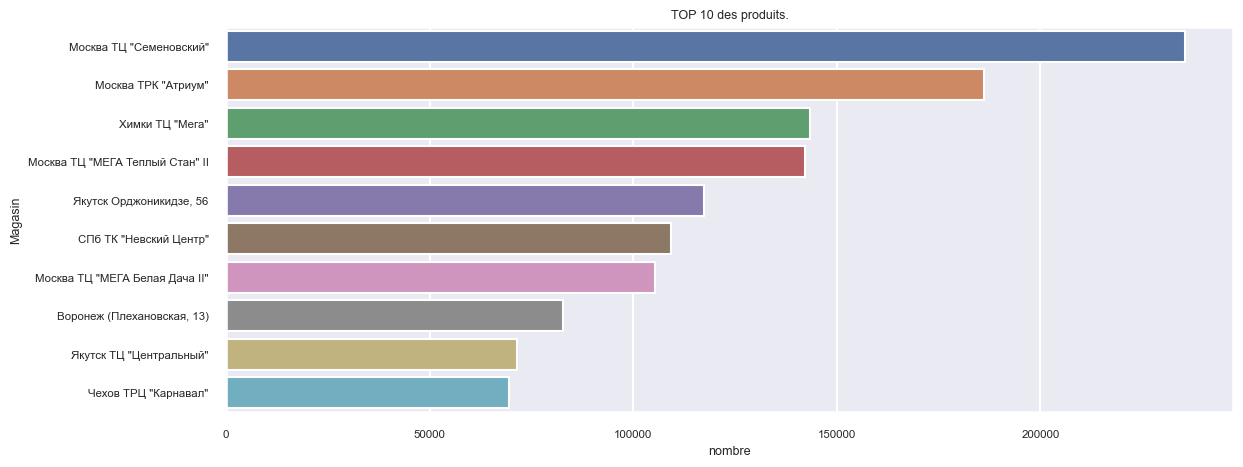

In [101]:
top_10_selling_item = base['shop_name'].value_counts().head(10)
top_10_selling_item = top_10_selling_item.to_frame().reset_index()
top_10_selling_item.columns = ['shop_name', 'count']
plt.figure(figsize=(13, 5))
sns.barplot(data=top_10_selling_item, x='count', y='shop_name')
plt.title('TOP 10 des produits.')
plt.ylabel('Magasin')
plt.xlabel('nombre')
plt.show()

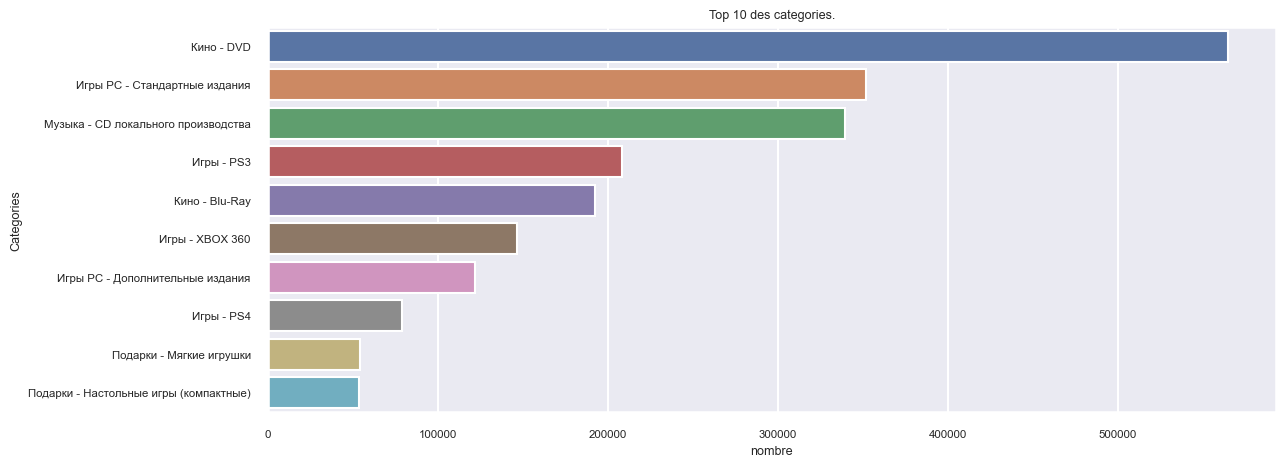

In [102]:
top_10_selling_category = base['item_category_name'].value_counts().head(10)
top_10_selling_category = top_10_selling_category.to_frame().reset_index()
top_10_selling_category.columns = ['item_name', 'count']
plt.figure(figsize=(13, 5))
sns.barplot(data=top_10_selling_category, x='count', y='item_name')
plt.title('Top 10 des categories.')
plt.ylabel('Categories')
plt.xlabel('nombre')
plt.show()

les différentes catégories de produits

c:\Users\dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


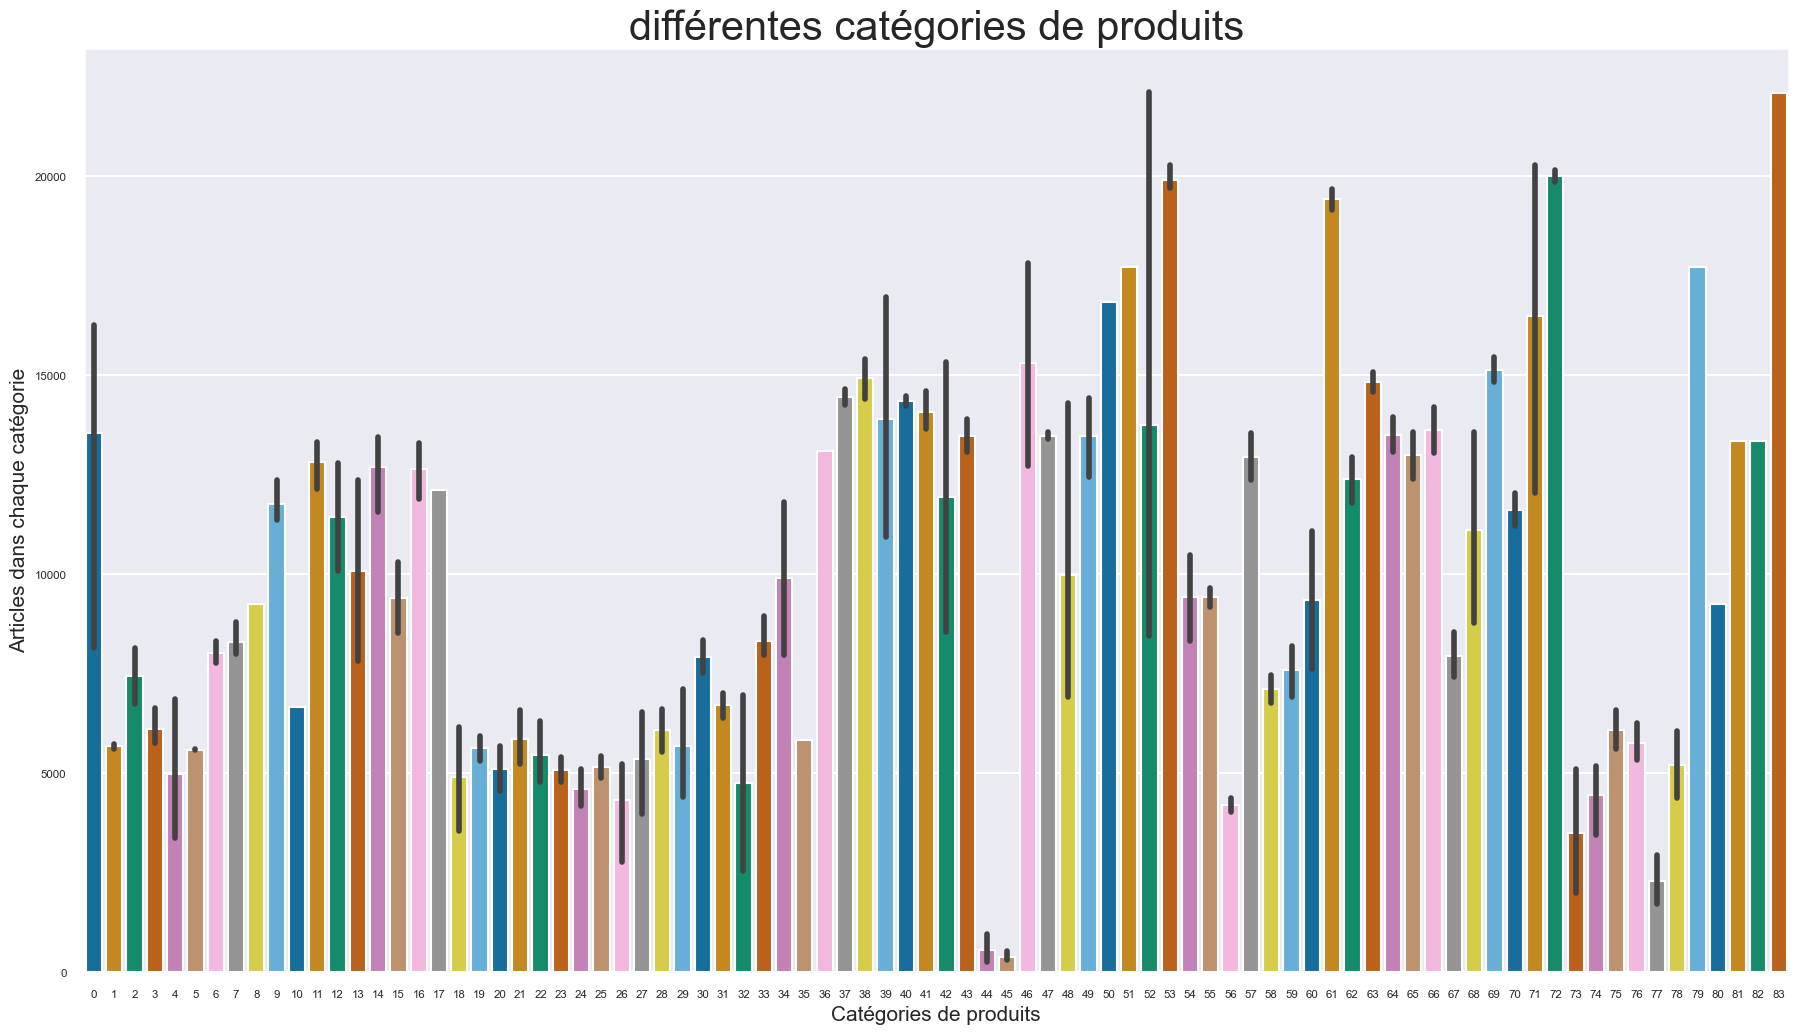

In [103]:
plt.rcParams['figure.figsize'] = (22, 12)
sns.barplot(items['item_category_id'], items['item_id'], palette = 'colorblind')
plt.title('différentes catégories de produits', fontsize = 30)
plt.xlabel('Catégories de produits', fontsize = 15)
plt.ylabel('Articles dans chaque catégorie', fontsize = 15)
plt.show()

## PANDAS PROFILING for EDA

In [104]:
profile = pp.ProfileReport(base, title = "Data Exploration")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
# convertir la target en integer
base['item_cnt_day'] = base['item_cnt_day'].astype(np.int64)
base.dtypes

date                  datetime64[ns]
date_block_num                  int8
shop_id                         int8
item_id                        int16
item_price                   float32
item_cnt_day                   int64
shop_name                     object
item_name                     object
item_category_id                int8
item_category_name            object
dtype: object



Nous réalisons que la variable cible item_cnt_day a les valeurs negatives (la valeur minimale est -22). Il est impossible de vendre moins de 0 produits par jour.

Supposons qu'il s'agisse d'une erreur de frappe. Par exemple, au lieu de mettre une valeur de 22, le manager a mi -22. Il suffit donc de multiplier les valeurs négatives par -1.


In [26]:
multiply_by_minus_one = lambda x: x * -1 \
                        if x < 0         \
                        else x

base['item_cnt_day'] = base['item_cnt_day'].apply(multiply_by_minus_one)

base.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06   
mean     1.456991e+01  3.300171e+01  1.019723e+04  8.906237e+02  1.247779e+00   
std      9.422992e+00  1.622698e+01  6.324293e+03  1.726442e+03  2.616393e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00  1.000000e+00   
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

       item_category_id  
count      2.935843e+06  
mean       4.000141e+01  
std        1.710076e+01  
min        0.000000e+00  
25%        2.800000e+01  
50%        4.000000e+01  
75%        5.500000e+01  
max        8.300000e+01

## Preprocessing

Outliers

<AxesSubplot:xlabel='item_price'>

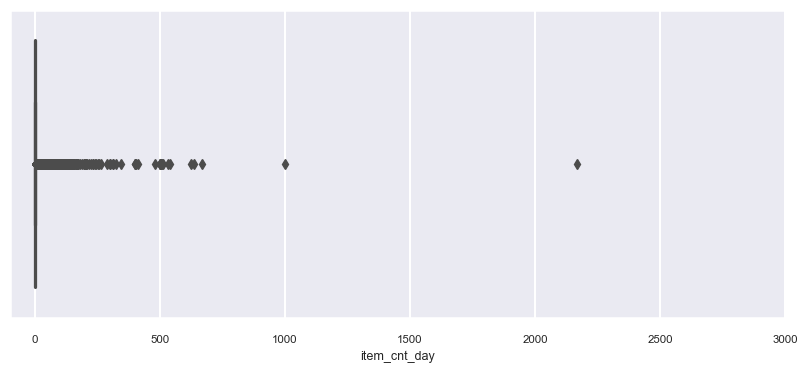

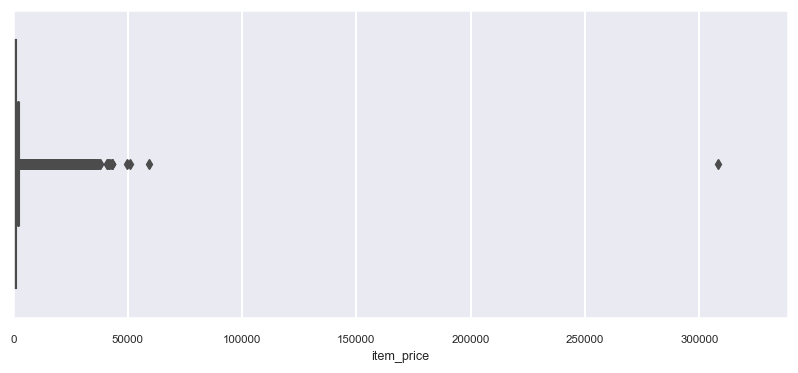

In [120]:

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=base.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(base.item_price.min(), base.item_price.max()*1.1)
sns.boxplot(x=base.item_price)


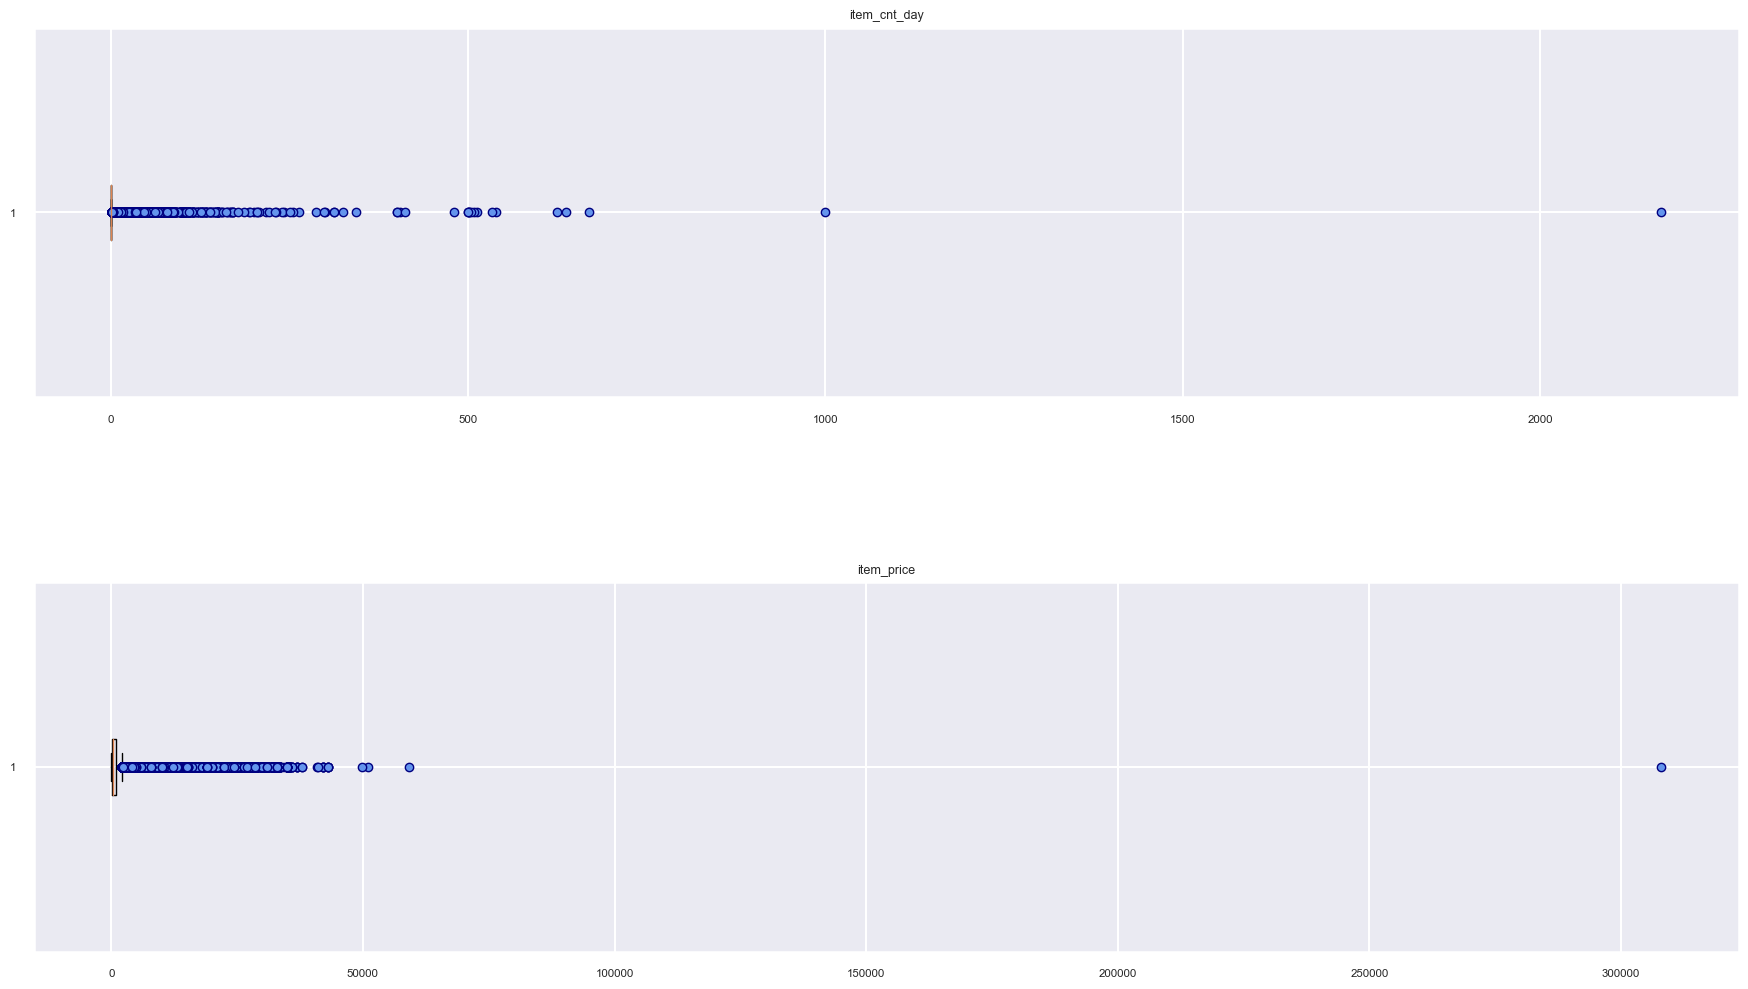

In [121]:
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5)

flierprops = dict(marker='o', markerfacecolor='cornflowerblue', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=base.item_cnt_day, flierprops=flierprops, vert=False)
_ = axes[1].boxplot(x=base.item_price, flierprops=flierprops, vert=False)

_ = axes[0].set_title('item_cnt_day')
_ = axes[1].set_title('item_price')

In [27]:
base = base[base.item_price<100000]
base = base[base.item_cnt_day<1001]
base = base[base['item_price'] > 0]
base = base[base['item_cnt_day'] > 0]


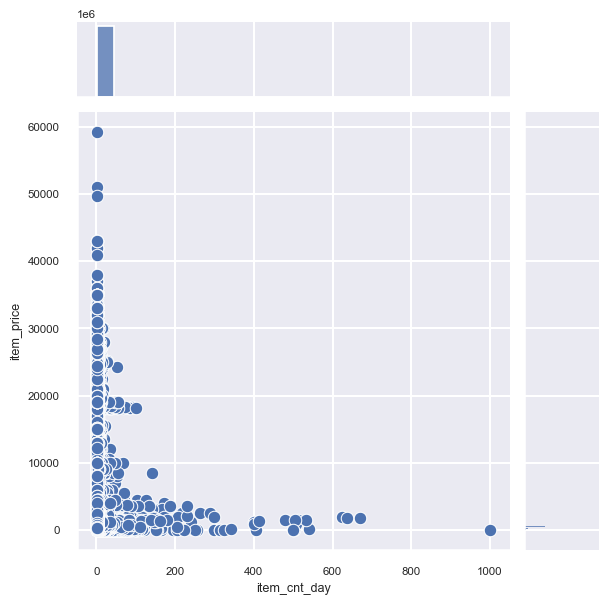

In [ ]:
sns.jointplot(x="item_cnt_day", y="item_price", data=base)
plt.show()

ajoutons la variable revenue

In [28]:
base['revenue'] = base['item_price'] *  base['item_cnt_day']

In [29]:
## Merge some duplicate shops
base["shop_id"] = base["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# Keep only shops that are in the test set
base = base.loc[base.shop_id.isin(test["shop_id"].unique()), :]
base.dropna(axis=1,inplace=True)

In [30]:
daily = base[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
daily = daily.groupby(['date'], as_index=False)
daily = daily.agg({'item_cnt_day':['sum']})
daily.head()

date item_cnt_day
                      sum
0 2013-01-01         1121
1 2013-01-02         2960
2 2013-01-03         3121
3 2013-01-04         2052
4 2013-01-05         3802

In [31]:
monthly_per_shop = base[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
monthly_per_shop = monthly_per_shop.groupby(['date_block_num','shop_id'], as_index=False)
monthly_per_shop = monthly_per_shop.agg({'item_cnt_day':['sum']})
monthly_per_shop['item_cnt_month']  = monthly_per_shop['item_cnt_day']['sum']
monthly_per_shop = monthly_per_shop.drop(['item_cnt_day'], axis=1)
monthly_per_shop.head()

C:\Users\dell\AppData\Local\Temp\ipykernel_8704\34896550.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  monthly_per_shop = monthly_per_shop.drop(['item_cnt_day'], axis=1)


date_block_num shop_id item_cnt_month
                                       
0              0       2           1156
1              0       3            767
2              0       4           2120
3              0       6           3712
4              0       7           2501

Séparons la ville et le nom de la boutique

In [32]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'

In [33]:

shops["city"] = shops.shop_name.str.split(' ').map(lambda x: x[0])

In [34]:
shops["shop_category"] = shops.shop_name.str.split(" ").map(lambda x: x[1])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск" 

In [35]:
from sklearn.preprocessing import LabelEncoder

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])
# Shop Category Label Encoding 
shops['shop_category'] = label_encoder.fit_transform(shops['shop_category'])

In [36]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

shop_id  city  shop_category
0        0    29              4
1        1    29              8
2        2     0              8
3        3     1              6
4        4     2              8

In [37]:
items = items.drop(['item_name'], axis=1)

In [38]:
items['first_sale_date'] = base.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

item_id  item_category_id  first_sale_date
0        0                40              NaN
1        1                76             15.0
2        2                40              NaN
3        3                40              NaN
4        4                40              NaN

In [39]:
items[items['first_sale_date'].isna()]

item_id  item_category_id  first_sale_date
0            0                40              NaN
2            2                40              NaN
3            3                40              NaN
4            4                40              NaN
5            5                40              NaN
...        ...               ...              ...
21975    21975                61              NaN
22022    22022                40              NaN
22028    22028                40              NaN
22035    22035                40              NaN
22137    22137                40              NaN

[1085 rows x 3 columns]

In [40]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

In [41]:
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  
item_categories['category'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: category, dtype: int64

In [42]:
def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

In [43]:
# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc)

In [44]:
# Create Label Encoder
label_encoder = LabelEncoder()

In [45]:
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

In [46]:
item_categories = item_categories.drop('item_category_name', axis=1)

In [47]:
from itertools import product

train = []
# Create date_block_num, shop_id, item_id combination
for i in base['date_block_num'].unique():
    all_shop = base.loc[base['date_block_num']==i, 'shop_id'].unique()
    all_item = base.loc[base['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

In [48]:
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [49]:
group = base.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

In [50]:

train = train.merge(group, on=idx_features, how='left')

train.head()

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean
0               0       59    22154             1.0            999.0
1               0       59     2552             NaN              NaN
2               0       59     2554             NaN              NaN
3               0       59     2555             NaN              NaN
4               0       59     2564             NaN              NaN

In [51]:
import gc

del group
gc.collect();

group = base.groupby(idx_features).agg({'item_cnt_day': 'sum'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

del group, base
gc.collect()

train.head()

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
0               0       59    22154             1.0            999.0   
1               0       59     2552             NaN              NaN   
2               0       59     2554             NaN              NaN   
3               0       59     2555             NaN              NaN   
4               0       59     2564             NaN              NaN   

   item_count  
0         1.0  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [52]:
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head()

date_block_num  shop_id  item_id  item_cnt_month  item_price_mean  \
0               0       59    22154             1.0            999.0   
1               0       59     2552             0.0              0.0   
2               0       59     2554             0.0              0.0   
3               0       59     2555             0.0              0.0   
4               0       59     2564             0.0              0.0   

   item_count  
0         1.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [53]:
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

In [54]:
all_data = downcast(all_data)

59.0% compressed


In [55]:
del shops, items, item_categories
gc.collect();

In [56]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary
resumetable(all_data)

Data Shape: (8861271, 11)


Dtypes  Null  Uniques  First_values  Second_values  \
date_block_num       int8     0       35           0.0            0.0   
shop_id              int8     0       42          59.0           59.0   
item_id             int16     0    21469       22154.0         2552.0   
item_cnt_month      int16     0      407           1.0            0.0   
item_price_mean   float32     0    34251         999.0            0.0   
item_count          int16     0      407           1.0            0.0   
city                 int8     0       28          30.0           30.0   
shop_category        int8     0       11           8.0            8.0   
item_category_id     int8     0       84          37.0           58.0   
first_sale_date      int8     0       35           0.0            0.0   
category             int8     0       10           5.0            7.0   

                  Third_values  
date_block_num             0.0  
shop_id                   59.0  
item_id                 2554.0  
item_cnt_month             0.0  
item_price_mean            0.0  
item_count                 0.0  
city                      30.0  
shop_category              8.0  
item_category_id          58.0  
first_sale_date            0.0  
category                   7.0

In [73]:
final_train_df = all_data[all_data.date_block_num<=27]
final_test_df = all_data[all_data.date_block_num>27]

y_train = final_train_df[["item_cnt_month"]]
x_train = final_train_df.drop("item_cnt_month", axis = 1)
 
y_test = final_test_df[["item_cnt_month"]] 
x_test = final_test_df.drop("item_cnt_month", axis = 1)


In [74]:
from sklearn.linear_model import LinearRegression


Modele = LinearRegression(fit_intercept = True)
Modele.fit(x_train, y_train)
train_score = Modele.score(x_train, y_train)
test_score = Modele.score(x_test, y_test)

train_score, test_score

(0.999999999996347, 0.9999999999950988)

In [75]:
from sklearn.linear_model import Lasso

Modele_lasso = Lasso(fit_intercept = True, alpha = 5)
Modele_lasso.fit(x_train, y_train)
train_score = Modele_lasso.score(x_train, y_train)
test_score = Modele_lasso.score(x_test, y_test)

train_score, test_score 

(0.8046604720375752, 0.8023881783771696)

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

Modele_SGB = GradientBoostingRegressor()
Modele_SGB.fit(x_train, y_train)
train_score = Modele_SGB.score(x_train, y_train)
test_score = Modele_SGB.score(x_test, y_test)

train_score, test_score 


c:\Users\dell\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9999238783949727, 0.9872712728327262)

In [61]:
from xgboost import XGBRegressor

In [62]:
# Creating the Model
xgb_model = XGBRegressor(
    n_estimators=500
    , learning_rate=0.05
    , n_jobs=4
)

In [63]:
xgb_model.fit(
    x_train, y_train
    , early_stopping_rounds=5
    , eval_set=[(x_test, y_test)]
    , verbose=False
)
print('Training: Done!')

xgb_predictions = xgb_model.predict(x_test)
print('Predictions: Done!')

c:\Users\dell\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training: Done!
Predictions: Done!


In [66]:
train_score =xgb_model.score(x_train, y_train)
test_score = xgb_model.score(x_test, y_test)

train_score, test_score

(0.7208950385781157, 0.41007231359369434)